Note to grader: Each question is assigned with a score. The final score will be (sum of actual scores)/(sum of maximum scores)*100. The grading rubrics are shown in the TA guidelines.


In [49]:
# Grader's area
import numpy as np
actualScore = 0
maxScore = 0


# **Assignment 6**
<br>

<font>

In [50]:
from IPython.display import Math
from IPython.display import Latex

import numpy as np
import os
import struct

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.neural_network import MLPClassifier

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

torch.manual_seed(0)

----------------
----------------
----------------

## <font color='blue'> **Question 1.** Visualizing convergence. </font>

Modify this code so that in every epoch it records:

**a.** The training loss, accuracy [10 pt] <br>
**b.** The test loss, accuracy [10 pt] 

Then:

**c.** Run the model for 20 epochs and give two plots (one for losses, one for accuracies) for the convergence behavior over 20 epochs. [10 pt]

<br>

**Note:**
Make sure you avoid updating the weights when you use the test set. For that you should consult the notebook from CNNs lecture. 




In [51]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# load smaller dataset to do assignment because whole dataset takes too long
#import torch.utils.data.Subset
subset_multiplier = 0.05;
subset_trainset_size = int(subset_multiplier * len(trainset))
subset_trainset_indices = torch.randperm(len(trainset))[:subset_trainset_size]# randperm returns 1d tensor with all unique integers
subset_trainset = torch.utils.data.Subset(trainset,subset_trainset_indices)
trainloader = torch.utils.data.DataLoader(subset_trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

subset_testset_size = int(subset_multiplier * len(testset))
subset_testset_indices = torch.randperm(len(testset))[:subset_testset_size]
subset_testset = torch.utils.data.Subset(testset,subset_testset_indices)
testloader = torch.utils.data.DataLoader(subset_testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [52]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # 3 input channels  ( r, g , b)
        # 6 output channels ( 6 learned features)
        # 5x5 filter, to learn feature in each output channel
        self.conv1 = nn.Conv2d(3, 6, 5)

        # 2x2 max pool reduce dimensionality
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(6, 16, 5)

        # fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    # inputs pass through here net(inputs)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flatten all dimensions except batch
        # Batch dimension contains the batches of data.
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # output layer
        return x

# initialize the model
net = Net()

In [53]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# pass reference of parameters to optimizer so it knows 
#       the networks weights and biases during training
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [54]:
# add training loss
# add testing loss

# given model and dataset (datapoints and labels) calculates the percentage of correctly classified points
def calculate_accuracy(model, dataloader):
    sample_count = len(dataloader)
    correct_count=0
    for data in dataloader:
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct_count += (predicted == labels).sum().item()

    accuracy = (correct_count / sample_count) * 100
    return accuracy
    
for epoch in range(2):  # loop over the dataset multiple times
    epoch_training_loss =0
    epoch_testing_loss=0
    running_loss = 0.0

    # a.
    #Trainig data
    for i, data in enumerate(trainloader):
        # looking at minibatch
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step() # update model to make more accurate

        running_loss += loss.item()
        epoch_training_loss += loss.item()

        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[Epoch {epoch + 1}, datapoint {i + 1:5d}] minibatch loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

    # This should be cross entropy
    print(f'Average cross entropy training loss for epoch {epoch+1}: {epoch_training_loss / len(trainloader)}')
     # calculate accuracy
    training_accuracy = calculate_accuracy(net,trainloader);
    
    print(f'Training accuracy for epoch {epoch+1}: {training_accuracy}%')

    # b.
    # get loss and accuracy on test data
    for i, data in enumerate(testloader, 0):
        inputs, labels = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        epoch_testing_loss += loss.item()
    # This should be cross entropy
    print(f'Average cross entropy testing loss for epoch {epoch+1}: {epoch_testing_loss / len(trainloader)}')

     # calculate accuracy
    testing_accuracy = calculate_accuracy(net,testloader);
    
    print(f'Testing accuracy for epoch {epoch+1}: {testing_accuracy}%')
print('Finished Training')

Average cross entropy training loss for epoch 1: 2.2997081943511963
Training accuracy for epoch 1: 61.919999999999995%
Average cross entropy testing loss for epoch 1: 0.45857417526245114
Testing accuracy for epoch 1: 61.6%
Average cross entropy training loss for epoch 2: 2.262572098350525
Training accuracy for epoch 2: 81.44%
Average cross entropy testing loss for epoch 2: 0.43724752464294436
Testing accuracy for epoch 2: 74.4%
Finished Training


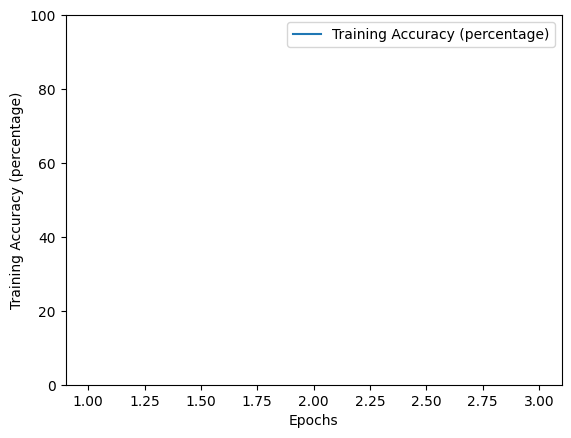

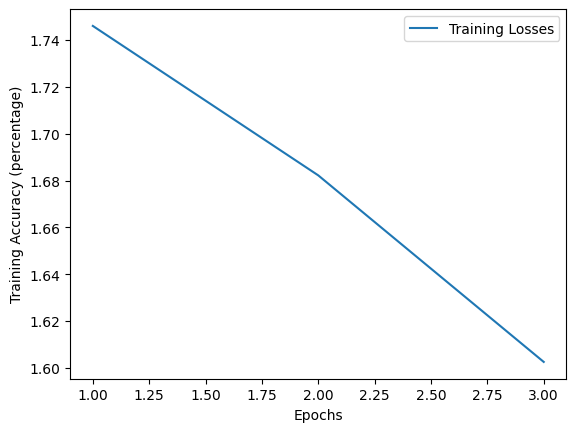

In [56]:
### Your code here. Also give some comments about your findings

#c. Run the model for 20 epochs and give two plots (one for losses, one for accuracies) for the convergence behavior over 20 epochs.
train_losses = []
train_accuracies = []
# model picks up where it left off training (2 epochs)

# def calculate_accuracy(model, dataloader):
#     sample_count = len(dataloader)
#     correct_count=0
#     for data in dataloader:
#         inputs, labels = data
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs, 1)
#         correct_count += (predicted == labels).sum().item()

#     accuracy = (correct_count / sample_count) * 100
#     return accuracy

epochs = 3
for epoch in range(epochs):
    epoch_crossentropy_loss = 0
    epoch_correct_count = 0
    for minibatch in trainloader:
        inputs, labels = minibatch
        optimizer.zero_grad()
        outputs = net(inputs)
        
        _, predicted = torch.max(outputs, 1)
        epoch_correct_count += (predicted == labels).sum().item()
        
        loss = criterion(outputs, labels)
        epoch_crossentropy_loss+=loss
        loss.backward()
        optimizer.step()
    # calculate the losses and accuracies for the epoch
    average_epoch_loss = epoch_crossentropy_loss/len(trainloader)
    epoch_accuracy = (epoch_correct_count / len(trainloader))*100
    train_losses.append(float(average_epoch_loss))
    train_accuracies.append(epoch_accuracy)


plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy (percentage)')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy (percentage)')
plt.ylim(0,100)
plt.legend()
plt.show()

plt.plot(range(1, epochs+1), train_losses, label='Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy (percentage)')
plt.legend()
plt.show()

print(train_accuracies[0:100])

In [ ]:
# For grader use only


maxScore = maxScore + 30


------------------------------
------------------------------
------------------------------

## <font color='blue'> **Question 2.** Learning random labels. </font>

Reuse the above code, but instead of using the given input labels on the training set, use random labels. Then run for 40 epochs. 
<br>

**a.** Report the plots for the training accuracy. **[10 pt]** <br>
**b.** What is the final training accuracy and final testing accuracy? **[10 pt]** <br>
**c.** What would be the expected accuracy for a random baseline model? **[10 pt]**





In [ ]:
## your code goes here

# initialize the model
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# a. plotting training accuracy per epoch
train_accuracies = []
epochs = 5

# get labels 
training_labels = torch.tensor([])
for data in trainloader:
    inputs,labels=data
    training_labels = torch.cat([training_labels,labels],dim=0)
#print("Successfully got training labels.")


for epoch in range(epochs):
    epoch_training_loss = 0
    epoch_outputs = torch.tensor([])
    epoch_correct_count=0
    for data in trainloader:
        # dont need labels cause we using random ones
        inputs,_ = data
        random_labels = torch.randint(0,10,(4,))
        optimizer.zero_grad()

        #net inputs is 4 tensors

        # outputs represents probability for each class
        outputs = net(inputs)
        
        epoch_outputs = torch.cat([epoch_outputs,net(inputs)],dim=0)
        
        loss=criterion(outputs, random_labels)
        loss.backward()
        optimizer.step()
        epoch_training_loss += loss.item()

    # accuracy of epoch
    # indexes represent the classes that the model things is the correct one
    values, indexes = torch.max(epoch_outputs, 1)

    # predicted 
    #print(labels)
    epoch_correct_count += (indexes == training_labels).sum().item()
    train_accuracy = (epoch_correct_count / len(training_labels)) * 100
    train_accuracies.append(train_accuracy)
        
    #train_accuracy = calculate_accuracy(net,trainloader)
    #print(f'Training accuracy for epoch {epoch+1}: {train_accuracy}')
    
# plot
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy (percentage)')
plt.ylim(0,100)
plt.legend()
plt.show()

# b. 

print(f'Final training accuracy: {calculate_accuracy(net,trainloader)}%')
print(f'Final testing accuracy: {calculate_accuracy(net,testloader)}%')

# c.

# The expected accuracy for a random baseline model would be 10% since there are 10 classes in total.


In [ ]:
# For grader use only


maxScore = maxScore + 30


------------------------------
------------------------------
------------------------------

## <font color='blue'> **Question 3.** Modifying the model for MNIST. </font>

Let's now work with the MNIST dataset. 
<br>

**a.** Download and prepare the dataloaders for the standard MNIST dataset. **[10 pt]** <br>
**b.** Modify the model so that it works with the MNIST dataset. The inner array sizes should be roughly similar, but you can adjust them in the way you choose **[20 pt]** <br>
**c.** Report the training and test accuracy after 10 epochs **[10 pt]**





In [ ]:
## your code goes here

#a. 
# applied before loading images in nnet
transform = torchvision.transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])

trainset = torchvision.datasets.MNIST("./data",download = True, train=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,shuffle=True)

testset = torchvision.datasets.MNIST("./data",download=True,train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset,batch_size=64,shuffle=False)

#b. 
# change the input channels to 1 (mnist is grayscale)
net.conv1 = nn.Conv2d(1, 6, 5)

# when 28x28 dataset does a forward pass, it losses dimensionality and becomes 4x4 and 16 output channels on final conv layer.

net.fc1 = nn.Linear(16*4*4, 120)
# reset model parameters (training on new dataset)
for layer in net.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

for epoch in range(10):
    epoch_training_loss = 0
    for data in trainloader:
        # dont need labels cause we using random ones
        inputs,labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss=criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_training_loss += loss.item()
    
    print(f'Training accuracy for epoch {epoch+1}: {calculate_accuracy(net,trainloader)}%')

final_training_accuracy = calculate_accuracy(net,trainloader)
final_testing_accuracy = calculate_accuracy(net,testloader)
print(f'Training accuracy after 10 epochs: {final_training_accuracy}')
print(f'Testing accuracy after 10 epochs: {final_testing_accuracy}')


In [ ]:
# For grader use only



maxScore = maxScore + 40


------------------------------
------------------------------
------------------------------

## <font color='blue'> **Question 4.** MNIST on randomly permuted images. [**optional**]</font>

In this question we will see whether a CNN remains as effective for randomly permuted images. 
<br>

**a.** Find a way to randomly permute the entries of a 2d array in numpy or a 2d tensor in PyTorch. This should be 2-3 lines of code - feel free to discuss it on Canvas. **[10 pt]** <br>
**b.** Train the model from question 3 on a training set where the images in the training set have re-arranged in a **random** way, which however is the **same** across all images. **[20 pt]** <br>
**c.** Report the training and test accuracy after 10 epochs, and after 20 epochs. **[10 pt]**





In [ ]:
## your code goes here















In [ ]:
# For grader use only


maxScore = maxScore + 40

In [ ]:
# for grader use

# Total Grade Calculation

score = actualScore*100/maxScore